## Preprocessing 

In [ ]:
import mne
import pandas as pd
import numpy as np
import os
from scipy.signal import butter, filtfilt

# EEG channels to be used
eeg_channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 
                'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

# Bandpass filter function
def butter_bandpass_filter(data, lowcut=0.5, highcut=50, fs=256, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)  # Apply along time axis

# Function to extract EEG segments with overlap
def extract_segments(raw_data, start_time, end_time, fs, segment_duration, overlap_fraction=0.5):
    """Extracts overlapping EEG segments with the specified overlap fraction."""
    segments = []
    start_sample = int(start_time * fs)
    end_sample = int(end_time * fs)
    
    overlap_samples = int(overlap_fraction * segment_duration * fs)  # Calculate the overlap in samples
    
    for seg_start in range(start_sample, end_sample, int((segment_duration - overlap_fraction * segment_duration) * fs)):  
        seg_end = seg_start + (segment_duration * fs)
        if seg_end <= raw_data.shape[1]:  # Ensure valid segment range
            segments.append(raw_data[:, seg_start:seg_end])  
    return segments

# Function to process a single EDF file
def process_edf(edf_path, annotation_path, participant_name, slider_values, fs=256, segment_duration=3, overlap_fraction=0.5):
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    raw.pick_channels(eeg_channels)  # Select only EEG channels
    data = raw.get_data()

    # Apply bandpass filter before converting to µV
    data = butter_bandpass_filter(data, lowcut=0.5, highcut=50, fs=fs)

    # Convert EEG data to µV
    data *= 1e6  

    # Load participant-specific annotations
    annotations = pd.read_csv(annotation_path)
    segments = []
    labels = []

    for (start_label, end_label, slider_col, segment_label) in [
        ("T1 Learning Start", "T1 Learning End", "Slider_39", "T1"),
        ("T2 Learning Start", "T2 Learning End", "Slider_44", "T2"),
        ("T3 Learning Start", "T3 Learning End", "Slider_45", "T3"),
    ]:
        try:
            start_time = annotations.loc[annotations["Name"] == start_label, "latency"].values[0]
            end_time = annotations.loc[annotations["Name"] == end_label, "latency"].values[0]
            label_value = slider_values.loc[slider_values["Name"] == participant_name, slider_col].values[0]

            segment_data_list = extract_segments(data, start_time, end_time, fs, segment_duration, overlap_fraction)

            for segment_data in segment_data_list:
                # Use full segment (not just mean)
                segment_flattened = segment_data.flatten()  # Retain all values
                segments.append(segment_flattened)
                labels.append(label_value)

        except IndexError:
            print(f"⚠️ Missing annotation for {participant_name}, {start_label} - {end_label}")

    return pd.DataFrame(segments), pd.Series(labels)

# Main processing function
def main(edf_folder, annotation_folder, output_file, slider_file="./Slider/slider_values_female.xlsx"):
    slider_values = pd.read_excel(slider_file)
    all_data = pd.DataFrame()

    for participant in slider_values['Name']:
        edf_path = os.path.join(edf_folder, f"{participant}.edf")
        annotation_path = os.path.join(annotation_folder, f"{participant}.csv")

        if not os.path.exists(edf_path) or not os.path.exists(annotation_path):
            print(f"⚠️ Missing file for {participant}")
            continue

        segments_df, labels_series = process_edf(edf_path, annotation_path, participant, slider_values)
        segments_df['Label'] = labels_series.values
        segments_df['Participant'] = participant

        all_data = pd.concat([all_data, segments_df], ignore_index=True)

    all_data.to_csv(output_file, index=False)
    print(f"✅ Saved processed data to {output_file}")

# Example usage
main("./EDF/Female", "./excel annotations/Female", "DataAugmented_f.csv")


Extracting EDF parameters from f:\CognitionEEG\Implementaion Codes\FYP_AroSamSay\Updated_codes\GenderWise\EDF\Female\Nido.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7877999  =      0.000 ...  3938.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from f:\CognitionEEG\Implementaion Codes\FYP_AroSamSay\Updated_codes\GenderWise\EDF\Female\Devyani.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5841999  =      0.000 ...  2920.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from f:\CognitionEEG\Implementaion Codes\FYP_AroSamSay\Updated_codes\GenderWise\EDF\Female\Nanthana.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5563999  =      0.000 ...  2781.999 secs...
NOTE: pick_channels() i

In [6]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("DataAugmented_f.csv")

# Print the last column
print(df.iloc[:, -1])  # -1 selects the last column


0         Nido
1         Nido
2         Nido
3         Nido
4         Nido
         ...  
3603    Suhani
3604    Suhani
3605    Suhani
3606    Suhani
3607    Suhani
Name: Participant, Length: 3608, dtype: object


In [7]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("DataAugmented_f.csv")

label_counts = df.iloc[:, -2].value_counts()
print(label_counts)


Label
Confusion      2178
Anxiety         807
Frustration     623
Name: count, dtype: int64


In [11]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("DataAugmented_f.csv")

# Move "Name" column (last) to the first position
df.insert(0, "Name", df.pop("Participant"))  # Moves last "Name" column to the beginning

# Shuffle the rows randomly
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffles the data

# Save the shuffled dataset
df.to_csv("Shuffled_DataAugmented_f.csv", index=False)

print("✅ Shuffled dataset saved as Shuffled_DataAugmentated.csv")


✅ Shuffled dataset saved as Shuffled_DataAugmentated.csv


## Feature Extraction

In [12]:
%pip install mne-features antropy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [13]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.signal import welch
import pywt
import antropy as ant
from mne_features.univariate import compute_hjorth_mobility, compute_hjorth_complexity

# EEG frequency bands (Hz)
bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 50),
}

# Function to calculate band power
def bandpower(data, sf, band):
    low, high = band
    freqs, psd = welch(data, sf, nperseg=sf*2)
    band_power = np.trapz(psd[(freqs >= low) & (freqs <= high)], dx=np.diff(freqs).mean())
    return band_power / np.trapz(psd, dx=np.diff(freqs).mean())  # Normalized power

# Function to compute wavelet energy
def wavelet_energy(data, wavelet='db4'):
    coeffs = pywt.wavedec(data, wavelet, level=4)
    energy = [np.sum(np.abs(c)**2) for c in coeffs]
    return energy

# Function to compute all features
def extract_features(segment, fs=256):
    features = {}
    for ch in range(segment.shape[0]):  # Each EEG channel
        data = np.array(segment[ch], dtype=np.float64)

        # Hjorth Parameters
        features[f'Ch{ch}_Hjorth_Mobility'] = compute_hjorth_mobility(data)
        features[f'Ch{ch}_Hjorth_Complexity'] = compute_hjorth_complexity(data)

        # Statistical Features
        features[f'Ch{ch}_Mean'] = np.mean(data)
        features[f'Ch{ch}_Std'] = np.std(data)
        features[f'Ch{ch}_Kurtosis'] = kurtosis(data)
        features[f'Ch{ch}_Skewness'] = skew(data)

        # First & Second Differences
        first_diff = np.diff(data)
        second_diff = np.diff(first_diff)
        features[f'Ch{ch}_First_Diff_Mean'] = np.mean(first_diff)
        features[f'Ch{ch}_Second_Diff_Mean'] = np.mean(second_diff)

        # PSD using Welch’s method
        freqs, psd = welch(data, fs, nperseg=fs*2)
        max_power_idx = np.argmax(psd)
        features[f'Ch{ch}_Max_Power'] = psd[max_power_idx]
        features[f'Ch{ch}_Max_Power_Freq'] = freqs[max_power_idx]

        # Relative Band Power (RBP)
        for band, freq_range in bands.items():
            features[f'Ch{ch}_RBP_{band}'] = bandpower(data, fs, freq_range)

        # Fractal Dimension
        features[f'Ch{ch}_Higuchi_FD'] = ant.higuchi_fd(data)
        features[f'Ch{ch}_Petrosian_FD'] = ant.petrosian_fd(data)

        # Wavelet Energy
        wavelet_feats = wavelet_energy(data)
        for i, val in enumerate(wavelet_feats):
            features[f'Ch{ch}_Wavelet_Energy_{i}'] = val

    return features

# Process EEG segments from CSV
def process_segments(input_file, output_file, n_channels=18):
    df = pd.read_csv(input_file)
    eeg_data = df.iloc[:, 1:-1]  # Remove Name and Label
    features_list = []

    for i in range(len(df)):
        sample = eeg_data.iloc[i].values
        n_samples = len(sample) // n_channels

        # Reshape into [channels x samples]
        segment = sample.reshape(n_channels, n_samples)
        features = extract_features(segment)

        # Add Name and Label back
        features['Name'] = df.iloc[i, 0]
        features['Label'] = df.iloc[i, -1]
        features_list.append(features)

    feature_df = pd.DataFrame(features_list)
    feature_df.to_csv(output_file, index=False)
    print(f"✅ Feature extraction completed. Saved to {output_file}")

# Run feature extraction
process_segments("Shuffled_DataAugmented_f.csv", "ExtractedFeatures_f.csv")


C:\Users\AroSamSay\AppData\Local\Temp\ipykernel_11336\230661365.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[(freqs >= low) & (freqs <= high)], dx=np.diff(freqs).mean())
C:\Users\AroSamSay\AppData\Local\Temp\ipykernel_11336\230661365.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return band_power / np.trapz(psd, dx=np.diff(freqs).mean())  # Normalized power


✅ Feature extraction completed. Saved to ExtractedFeatures_f.csv


In [14]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("ExtractedFeatures_f.csv")

# Move "Name" column (last) to the first position
df.insert(0, "Name", df.pop("Name"))  # Moves last "Name" column to the beginning



df.to_csv("ExtractedFeatures_f.csv", index=False)

# print("✅ Shuffled dataset saved as Shuffled_DataAugmentated.csv")


In [15]:
import pandas as pd
import numpy as np

# Load the extracted features CSV
file_path = "ExtractedFeatures_f.csv"  # Change if needed
df = pd.read_csv(file_path)

# Display basic info about the dataset
print("🔹 Dataset Information:")
print(df.info())

# Exclude non-numeric columns (e.g., participant names and labels)
numeric_df = df.select_dtypes(include=[np.number])

# Check for missing values
print("\n🔹 Checking for Missing Values:")
missing_values = numeric_df.isnull().sum().sum()
if missing_values > 0:
    print(f"⚠️ Warning: {missing_values} missing values found!")
    print(numeric_df.isnull().sum())
else:
    print("✅ No missing values found.")

# Check for NaN or infinite values only in numeric columns
print("\n🔹 Checking for NaN and Infinite Values:")
if np.any(np.isnan(numeric_df.values)) or np.any(np.isinf(numeric_df.values)):
    print("⚠️ Warning: NaN or infinite values detected in the dataset!")
else:
    print("✅ No NaN or infinite values found.")

# Display feature statistics
print("\n🔹 Feature Statistics:")
print(numeric_df.describe())

# Check if all expected features exist
expected_features = [
    "Hjorth_Mobility", "Hjorth_Complexity", "Mean", "Std", "Kurtosis", "Skewness",
    "First_Diff_Mean", "Second_Diff_Mean", "Max_Power", "Max_Power_Freq", 
    "Higuchi_FD", "Petrosian_FD", "Hurst_Exponent"
]
missing_features = [feature for feature in expected_features if not any(feature in col for col in numeric_df.columns)]

print("\n🔹 Checking for Missing Features:")
if missing_features:
    print(f"⚠️ Warning: The following features are missing: {missing_features}")
else:
    print("✅ All expected features are present.")

# Check label distribution
print("\n🔹 Checking Label Distribution:")
if "Label" in df.columns:
    print(df["Label"].value_counts())
else:
    print("⚠️ Warning: 'Label' column is missing!")

print("\n✅ Feature verification completed.")


🔹 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Columns: 398 entries, Name to Label
dtypes: float64(396), object(2)
memory usage: 11.0+ MB
None

🔹 Checking for Missing Values:
✅ No missing values found.

🔹 Checking for NaN and Infinite Values:
✅ No NaN or infinite values found.

🔹 Feature Statistics:
       Ch0_Hjorth_Mobility  Ch0_Hjorth_Complexity     Ch0_Mean      Ch0_Std  \
count          3608.000000            3608.000000  3608.000000  3608.000000   
mean              0.068258              11.440288    -0.007101    13.323582   
std               0.031111               7.875112     4.189063    47.278152   
min               0.014552               1.119174   -81.558439     1.579831   
25%               0.044445               5.241004    -0.417436     4.157486   
50%               0.064654               9.895920    -0.005032     6.038986   
75%               0.090570              15.233536     0.389456    10.724313   
max              

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the extracted features dataset
file_path = "ExtractedFeatures_f.csv"  # Update if needed
df = pd.read_csv(file_path)

# Separate Name and Label columns (if they exist)
name_col = "Name" if "Name" in df.columns else None
label_col = "Label" if "Label" in df.columns else None

# Drop non-numeric columns for normalization
numeric_df = df.drop(columns=[col for col in [name_col, label_col] if col], errors="ignore")

# Initialize MinMaxScaler (scales features between 0 and 1)
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(numeric_df)

# Create a new DataFrame with normalized values
normalized_df = pd.DataFrame(normalized_values, columns=numeric_df.columns)

# Restore Name and Label columns in correct order
if name_col:
    normalized_df.insert(0, name_col, df[name_col])  # Keep Name as the first column
if label_col:
    normalized_df[label_col] = df[label_col]  # Keep Label at the end

# Save the normalized dataset
output_file = "Normalized_Features_f.csv"
normalized_df.to_csv(output_file, index=False)

print(f"✅ Normalization complete. Saved to {output_file}.")


✅ Normalization complete. Saved to Normalized_Features_f.csv.


## ML

### SVM

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.75      0.31      0.44       228
   Confusion       0.69      0.97      0.81       656
 Frustration       1.00      0.34      0.51       199

    accuracy                           0.72      1083
   macro avg       0.81      0.54      0.58      1083
weighted avg       0.76      0.72      0.67      1083



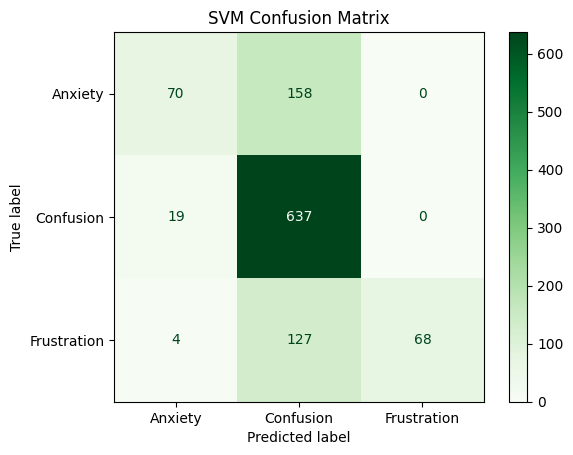

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load EEG data
data = pd.read_csv('Normalized_Features_f.csv')
X = data.iloc[:, 1:-1].values  # Features
y = data.iloc[:, -1].values    # Labels

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Train SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

# Evaluate
y_pred = svm_model.predict(X_test)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap='Greens')
plt.title("SVM Confusion Matrix")
plt.savefig("confusion_matrix_SVM_f.png")
plt.show()

### RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.88      0.76      0.81       228
   Confusion       0.85      0.97      0.90       656
 Frustration       0.95      0.65      0.77       199

    accuracy                           0.87      1083
   macro avg       0.89      0.79      0.83      1083
weighted avg       0.87      0.87      0.86      1083



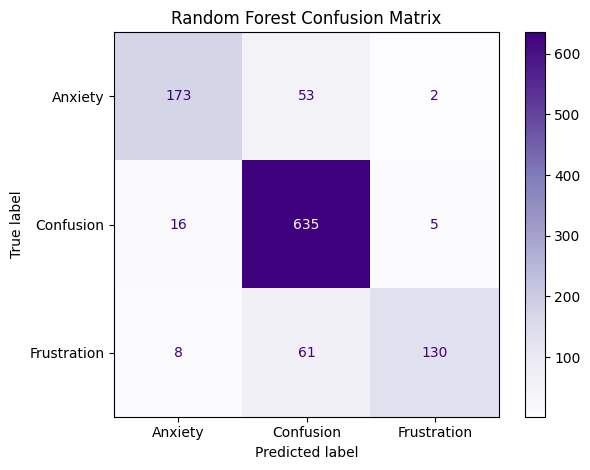

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load EEG data
data = pd.read_csv('Normalized_Features_f.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Purples')
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_RF_f.png")
plt.show()

### XG BOOST

In [19]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [13:38:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.90      0.82      0.86       228
   Confusion       0.91      0.96      0.93       656
 Frustration       0.91      0.82      0.87       199

    accuracy                           0.90      1083
   macro avg       0.90      0.87      0.88      1083
weighted avg       0.90      0.90      0.90      1083



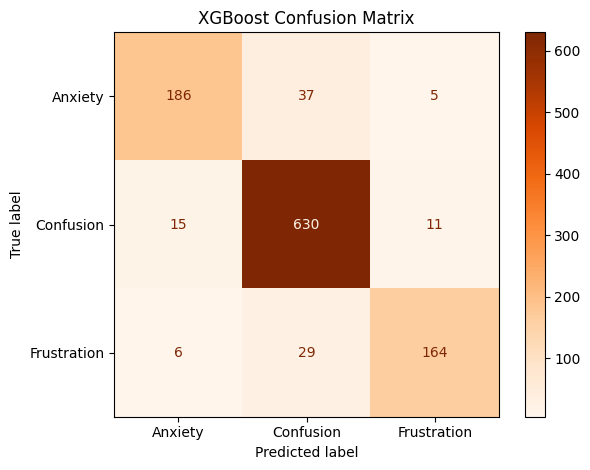

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# Load EEG data
data = pd.read_csv('Normalized_Features_f.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Initialize XGBoost model with hyperparameters
xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_XGBoost_f.png")
plt.show()

# Save the model in different formats
xgb_model.save_model("xgboost_model.json")  



### KNN

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.60      0.64      0.62       228
   Confusion       0.79      0.85      0.82       656
 Frustration       0.82      0.54      0.65       199

    accuracy                           0.75      1083
   macro avg       0.73      0.68      0.70      1083
weighted avg       0.75      0.75      0.75      1083



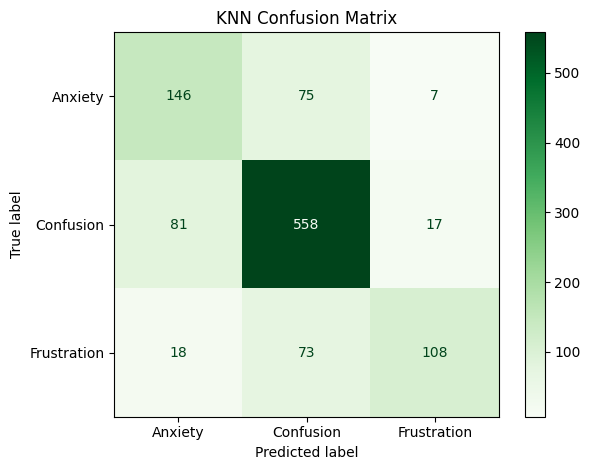

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('Normalized_Features_f.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Train KNN model with hyperparameter tuning (you can experiment with n_neighbors)
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # Euclidean distance
knn_model.fit(X_train, y_train)

# Predict
y_pred = knn_model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_KNN_f.png")
plt.show()